In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


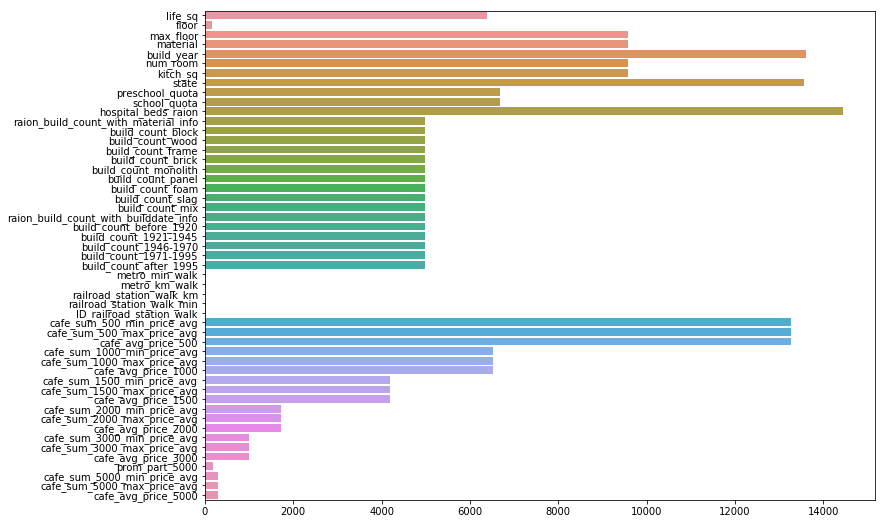

In [3]:
column_names = []
num_null_slots = []
null_ratio = []

for n in df_train.columns.values :
    null_val = df_train[n].isnull()
    num_null_val = np.sum(null_val)
    
    if num_null_val > 0 :
        num_null_slots.append(num_null_val)
        column_names.append(n)
        
        
fig,ax = plt.subplots()
fig.set_size_inches(12,9)
sns.barplot(num_null_slots,column_names)

In [4]:
len(df_train)

30471

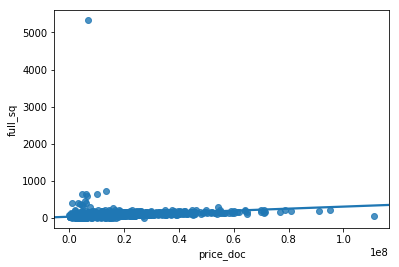

In [5]:
df_train['full_sq'].fillna(0,inplace=True)
df_train['price_doc'].fillna(0,inplace=True)

sns.regplot(x='price_doc',y='full_sq',data=df_train)

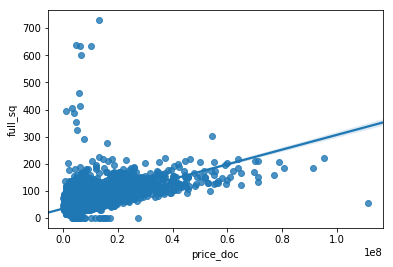

In [7]:
df_train = df_train.loc[df_train['full_sq'] < 2000]
sns.regplot(x='price_doc',y='full_sq',data=df_train)

In [8]:
def add_grouped_features(orig_df,group_col,agg_dict,destination_val) : 
    grouped = df_train.groupby(group_col).aggregate(agg_dict)
    grouped.columns = grouped.columns.droplevel(0)
    grouped.reset_index(inplace=True)
    
    for k in agg_dict.keys() : 
        ax = sns.lmplot(x=k,y=destination_val,hue=group_col,data=orig_df)

    ax = sns.jointplot(x=group_col,y=destination_val,data=orig_df,kind='hex')
    
    return pd.merge(left=orig_df,right=grouped,how='left',on=group_col)

c:\users\ice.cheshire\appdata\local\programs\python\python36\lib\site-packages\pandas\core\groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,living_area_ratio,median_full_sq,avg_full_sq,median_life_sq,avg_life_sq,median_la_ratio
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,0,52,4,5850000,0.627907,45.0,51.380989,29.0,32.632578,0.612903
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,10,66,14,6000000,0.558824,45.0,52.717635,29.0,34.101878,0.613636
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,4,67,10,5700000,0.674419,46.0,52.155880,29.0,32.704925,0.611111
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,0,26,3,13100000,0.561798,48.0,52.610418,30.0,32.300752,0.597403
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,91,195,14,16331452,1.000000,45.0,51.380989,29.0,32.632578,0.612903


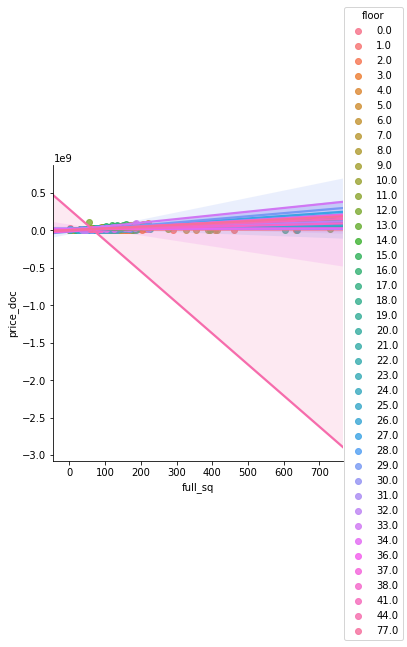

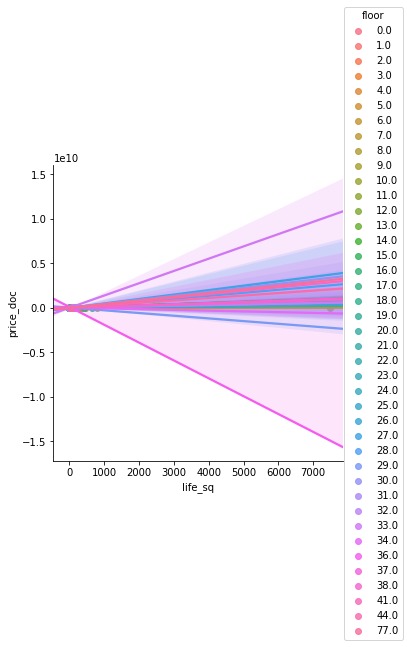

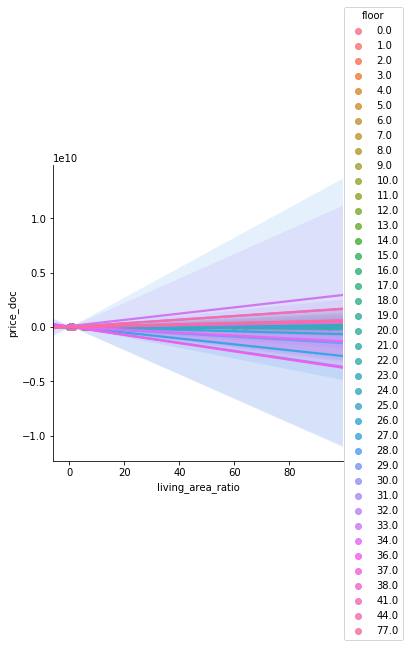

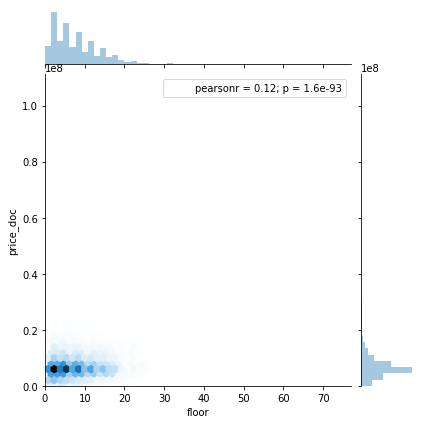

In [9]:
df_train.head()
df_train['living_area_ratio'] = df_train['life_sq'] / df_train['full_sq']
df_train = add_grouped_features(df_train,group_col = 'floor',agg_dict = {'full_sq' : {'median_full_sq' : 'median', 'avg_full_sq' : 'mean'},
                                                      'life_sq' : {'median_life_sq' : 'median', 'avg_life_sq' : 'mean',},
                                                       'living_area_ratio' : {'median_la_ratio' : 'median'}},destination_val='price_doc')
df_train.head()

c:\users\ice.cheshire\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:98: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


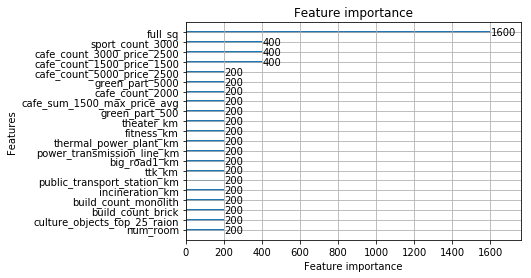

In [16]:
import lightgbm as lgb

d_train = lgb.Dataset(df_train.drop(['id','price_doc','timestamp', 'product_type', 'sub_area', 'culture_objects_top_25', 'thermal_power_plant_raion', 'incineration_raion', 'oil_chemistry_raion', 'radiation_raion', 'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion', 'detention_facility_raion', 'water_1line', 'big_road1_1line', 'railroad_1line', 'ecology'],axis=1),label=df_train['price_doc'])

param = {'objective' :'regression',
        'metric' : 'mse',
        'num_leaves' : 32,
        'max_depth' : 12,
        'num_rounds' : 200,
        'boosting' : 'gbdt'}

bst = lgb.train(param,d_train)
lgb.plot_importance(booster=bst)

In [17]:
df_train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,living_area_ratio,median_full_sq,avg_full_sq,median_life_sq,avg_life_sq,median_la_ratio
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,0,52,4,5850000,0.627907,45.0,51.380989,29.0,32.632578,0.612903
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,10,66,14,6000000,0.558824,45.0,52.717635,29.0,34.101878,0.613636
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,4,67,10,5700000,0.674419,46.0,52.155880,29.0,32.704925,0.611111
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,0,26,3,13100000,0.561798,48.0,52.610418,30.0,32.300752,0.597403
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,91,195,14,16331452,1.000000,45.0,51.380989,29.0,32.632578,0.612903
